In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm

# Need to move TRANSFORMERS and text_to_code_q6 to other script
from build_model_multinomial import TRANSFORMERS, text_to_code_q6, text_to_code_q10_2_binary, fallback_text_to_float, text_to_code_q10_2_binary_exclude_neither
from build_model_logistic import build_v2g_model_binary_from_df, run_single_feature_regressions, filter_significant_features
from get_data import init_column_map, pull_data_rowwise
from logistic_results_plot import (
    plot_feature_significance, 
    plot_odds_ratio_barh, 
    plot_p_value_barh, 
    plot_log_p_value_barh, 
    plot_coefficients_significance_barh, 
    plot_coefficient_vs_significance,
    plot_coefficients_barplot,
    plot_odds_ratios_barplot,
    plot_coefficients_by_abs,
    plot_binary_confusion_matrix,
    transform_and_plot_correlation
)

In [2]:
# Define all variable categories
from variables import (
    demographics, 
    input_variables_vehicle_ownership, 
    familiarity, 
    kms_driven, 
    renewables_at_home,
    parking, 
    q6a_cols, 
    energ_literacy, 
    renewables_at_home, 
    intent_to_purchase_vehicle,
    benefits_v2g, 
    concerns_v2g, 
    interest_in_services, 
    consider_using_NRMA_for,
    charging_control, 
    preference_on_batt_use, 
    expected_return,
    q6a_petrol, q6a_ev, q6a_plughyb, q6a_hybrid,
#     charging_control,
    feature_label_map
)

# 2. Model Setup

## 2.1. Initialise dataframe

In [3]:
csv_file = './data/survey_pre_processed_data.csv'

In [4]:
target_variable = 'Q10_2'  # "I would be interested in installing V2G..."

In [5]:
q10_2_categories = [
    "Strongly disagree",
    "Somewhat disagree",
    "Neither agree nor disagree",
    "Somewhat agree",
    "Strongly agree"
    ]

In [6]:
# Pull the data from CSV
init_column_map(csv_file)

columns_of_interest = (
    familiarity +
    kms_driven + 
    renewables_at_home + 
    q6a_cols + 
    demographics + 
    input_variables_vehicle_ownership + 
    parking + 
    benefits_v2g + 
    concerns_v2g +
    energ_literacy +
#   charging_control +
    [target_variable]
    )

rows = pull_data_rowwise(columns_of_interest, csv_file)

# Make a DataFrame
df = pd.DataFrame(rows, columns=columns_of_interest)
df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3,5,5,,,...,1,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1,Very familiar,"Less than 10,000",1,1,0,5,5,5,5,5,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
2,Not at all familiar,"20,001-50,000",0,0,1,2,1,2,,,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Strongly disagree
3,Not at all familiar,"Less than 10,000",0,0,1,,,,,,...,0,0,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,Somewhat disagree
4,Very familiar,"20,001-50,000",1,1,0,5,5,5,4,4,...,0,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,,,,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree
1354,Somewhat familiar,"Less than 10,000",0,0,1,5,5,5,,,...,0,0,1,0,1,0,Strongly agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1355,Very familiar,"10,000-20,000",1,0,0,4,4,5,4,4,...,0,1,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree
1356,Very familiar,"10,000-20,000",0,0,1,,,,3,5,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree


In [7]:
df['AgeBand']

0       Prefer not to say
1       Prefer not to say
2                     65+
3             55-64 years
4             45-54 years
              ...        
1353          55-64 years
1354                  65+
1355                  65+
1356                  65+
1357          55-64 years
Name: AgeBand, Length: 1358, dtype: object

## 2.2. Clean data

In [8]:
# Ensure "0 - Weekdays" is converted correctly
for col in q6a_cols:
    df[col] = df[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert all values to numbers

# Debugging: Check unique values in each column
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

Unique values in Q6ax1_1: [3. 5. 2. 4. 0. 1.]
Unique values in Q6ax1_2: [5. 1. 3. 2. 4. 0.]
Unique values in Q6ax1_3: [5. 2. 0. 4. 3. 1.]
Unique values in Q6ax2_1: [5. 4. 3. 1. 2. 0.]
Unique values in Q6ax2_2: [5. 4. 3. 2. 0. 1.]
Unique values in Q6ax2_3: [5. 4. 3. 1. 0. 2.]
Unique values in Q6ax3_1: [3. 1. 4. 0. 2. 5.]
Unique values in Q6ax3_2: [5. 4. 2. 3. 1.]
Unique values in Q6ax3_3: [5. 2. 3. 4.]
Unique values in Q6ax4_1: [0. 2. 5. 4. 3. 1.]
Unique values in Q6ax4_2: [5. 2. 3. 0. 4. 1.]
Unique values in Q6ax4_3: [5. 3. 0. 1. 4. 2.]


In [9]:
# Count missing responses for each charging question
missing_counts = (df[q6a_cols] == 0).sum()
# Display summary of non-responses per column
print("Number of responses recorded as 0:")
print(missing_counts)

Number of responses recorded as 0:
Q6ax1_1    118
Q6ax1_2     28
Q6ax1_3     31
Q6ax2_1    102
Q6ax2_2     24
Q6ax2_3     14
Q6ax3_1      4
Q6ax3_2      0
Q6ax3_3      0
Q6ax4_1     12
Q6ax4_2      6
Q6ax4_3      9
dtype: int64


In [10]:
# Checking number of vehicles per type
print(df[q6a_petrol + q6a_ev + q6a_plughyb + q6a_hybrid].notna().sum())

Q6ax1_1    874
Q6ax1_2    874
Q6ax1_3    874
Q6ax2_1    768
Q6ax2_2    768
Q6ax2_3    768
Q6ax3_1     33
Q6ax3_2     33
Q6ax3_3     33
Q6ax4_1    111
Q6ax4_2    111
Q6ax4_3    111
dtype: int64


## 2.3. Update transformers to consider Q10_2 as binary (other than multinomial)

In [11]:
# Make a copy of TRANSFORMERS and update it with Q6a mappings
TRANSFORMERS_q6a = TRANSFORMERS.copy()

In [12]:
# Update with Q6a_* variables (charging behavior questions)
TRANSFORMERS_q6a.update({
    **{q: text_to_code_q6 for q in q6a_petrol},  
    **{q: text_to_code_q6 for q in q6a_ev},      
    **{q: text_to_code_q6 for q in q6a_plughyb}, 
    **{q: text_to_code_q6 for q in q6a_hybrid}   
})

In [13]:
TRANSFORMERS_q6a[target_variable] = text_to_code_q10_2_binary
TRANSFORMERS_q6a

{'Q1_1': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_2': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_3': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_4': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_99': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q2': <function build_model_multinomial.text_to_code_q2(raw_ans)>,
 'Q3_1': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_2': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_3': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_4': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_5': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q7_1': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_2': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_3': <functio

# 3. Feature Selection - Univariate Logistic Regression Analysis

## 3.1. Full dataset

In [14]:
features_to_select = (
    familiarity + 
    kms_driven +
    renewables_at_home +
    input_variables_vehicle_ownership + 
    q6a_petrol + 
    q6a_ev + 
    q6a_hybrid +
    q6a_plughyb +
    parking +
    benefits_v2g + 
    concerns_v2g + 
#   charging_control +
    energ_literacy + 
    demographics
)

In [15]:
df[target_variable] = df[target_variable].apply(text_to_code_q10_2_binary)

# Ensure the target variable is binary (0 or 1)
df[target_variable] = df[target_variable].astype(int)

## 3.2. Vehicle at home habits

In [16]:
missing_q6a = df[q6a_cols].isna().sum()
print("Missing values per Q6a variable:\n", missing_q6a)

Missing values per Q6a variable:
 Q6ax1_1     484
Q6ax1_2     484
Q6ax1_3     484
Q6ax2_1     590
Q6ax2_2     590
Q6ax2_3     590
Q6ax3_1    1325
Q6ax3_2    1325
Q6ax3_3    1325
Q6ax4_1    1247
Q6ax4_2    1247
Q6ax4_3    1247
dtype: int64


In [17]:
df[q6a_cols] = df[q6a_cols].fillna(0)

In [18]:
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

Unique values in Q6ax1_1: [3. 5. 2. 0. 4. 1.]
Unique values in Q6ax1_2: [5. 1. 0. 3. 2. 4.]
Unique values in Q6ax1_3: [5. 2. 0. 4. 3. 1.]
Unique values in Q6ax2_1: [0. 5. 4. 3. 1. 2.]
Unique values in Q6ax2_2: [0. 5. 4. 3. 2. 1.]
Unique values in Q6ax2_3: [0. 5. 4. 3. 1. 2.]
Unique values in Q6ax3_1: [0. 3. 1. 4. 2. 5.]
Unique values in Q6ax3_2: [0. 5. 4. 2. 3. 1.]
Unique values in Q6ax3_3: [0. 5. 2. 3. 4.]
Unique values in Q6ax4_1: [0. 2. 5. 4. 3. 1.]
Unique values in Q6ax4_2: [0. 5. 2. 3. 4. 1.]
Unique values in Q6ax4_3: [0. 5. 3. 1. 4. 2.]


In [19]:
q6a_filters = {
    "petrol": (df["Q1_1"].astype(int) == 1),
    "ev": (df["Q1_2"].astype(int) == 1),
    "plug_hybrid": (df["Q1_3"].astype(int) == 1),
    "hybrid": (df["Q1_4"].astype(int) == 1),
}

## 3.3. Single feature regressions

In [20]:
results_df = run_single_feature_regressions(
    df=df,
    features_to_select=features_to_select,
    target_variable="Q10_2",
    q6a_petrol=q6a_petrol,
    q6a_ev=q6a_ev,
    q6a_plughyb=q6a_plughyb,
    q6a_hybrid=q6a_hybrid,
    q6a_filters=q6a_filters,
    TRANSFORMERS_q6a=TRANSFORMERS_q6a,
    feature_label_map=feature_label_map
)

Running Logistic Regression for: Q9
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q2
Total rows before filter: 1358
Valid rows after filtering: 1355
Running Logistic Regression for: Q8_1
Total rows before filter: 1358
Valid rows after filtering: 844
Skipping Q8_1 (constant value: 1.0)
Running Logistic Regression for: Q8_2
Total rows before filter: 1358
Valid rows after filtering: 303
Skipping Q8_2 (constant value: 1.0)
Running Logistic Regression for: Q8_99
Total rows before filter: 1358
Valid rows after filtering: 511
Skipping Q8_99 (constant value: 1.0)
Running Logistic Regression for: Q1_1
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q1_2
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q1_3
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q1_4
Total rows before filter: 1358
Valid rows a

Running Logistic Regression for: Q6ax4_3
Total rows before filter: 111
Valid rows after filtering: 111
Running Logistic Regression for: Q6ax3_1
Total rows before filter: 33
Valid rows after filtering: 33
Running Logistic Regression for: Q6ax3_2
Total rows before filter: 33
Valid rows after filtering: 33
Running Logistic Regression for: Q6ax3_3
Total rows before filter: 33
Valid rows after filtering: 33
Running Logistic Regression for: Q3_1
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q3_2
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q3_3
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q3_4
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q3_5
Total rows before filter: 1358
Valid rows after filtering: 1358
Skipping Q3_5 (constant value: 0)
Running Logistic Regression for: Q14_1
Total rows 

In [21]:
results_df.to_csv('results_df.csv', index=False)

In [22]:
results_df

,Feature,Accuracy,Coefficient,Odds Ratio,P-value,abs_coef
31,Q14 - None of these,0.701031,-4.118287,0.016272,1.155364e-24,4.118287
3,Owns Electric Vehicle,0.765096,2.353795,10.525443,4.333243e-75,2.353795
24,Saving on my energy bill by using my car batte...,0.669367,1.427070,4.166472,3.144531e-35,1.427070
33,Safety concerns,0.602356,-1.288862,0.275584,2.825642e-16,1.288862
42,Q15 - None of these,0.591311,-1.267225,0.281612,6.529814e-14,1.267225
0,How Familiar Are You with V2G?,0.702504,1.199640,3.318922,1.707031e-54,1.199640
23,Earning money from my car battery by selling e...,0.586892,1.180939,3.257430,3.031615e-17,1.180939
38,Impact on my EV warranty,0.555965,1.144111,3.139649,2.535241e-12,1.144111
2,Owns Petrol/Diesel Car,0.613402,-1.067156,0.343985,8.654324e-20,1.067156
27,Supporting the grid during high demand,0.564065,1.058049,2.880746,8.563457e-13,1.058049


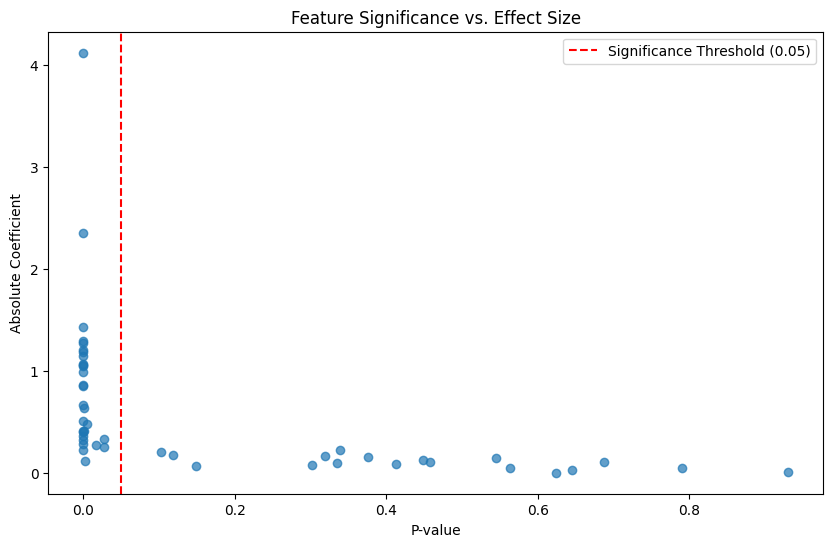

In [23]:
plot_feature_significance(results_df)

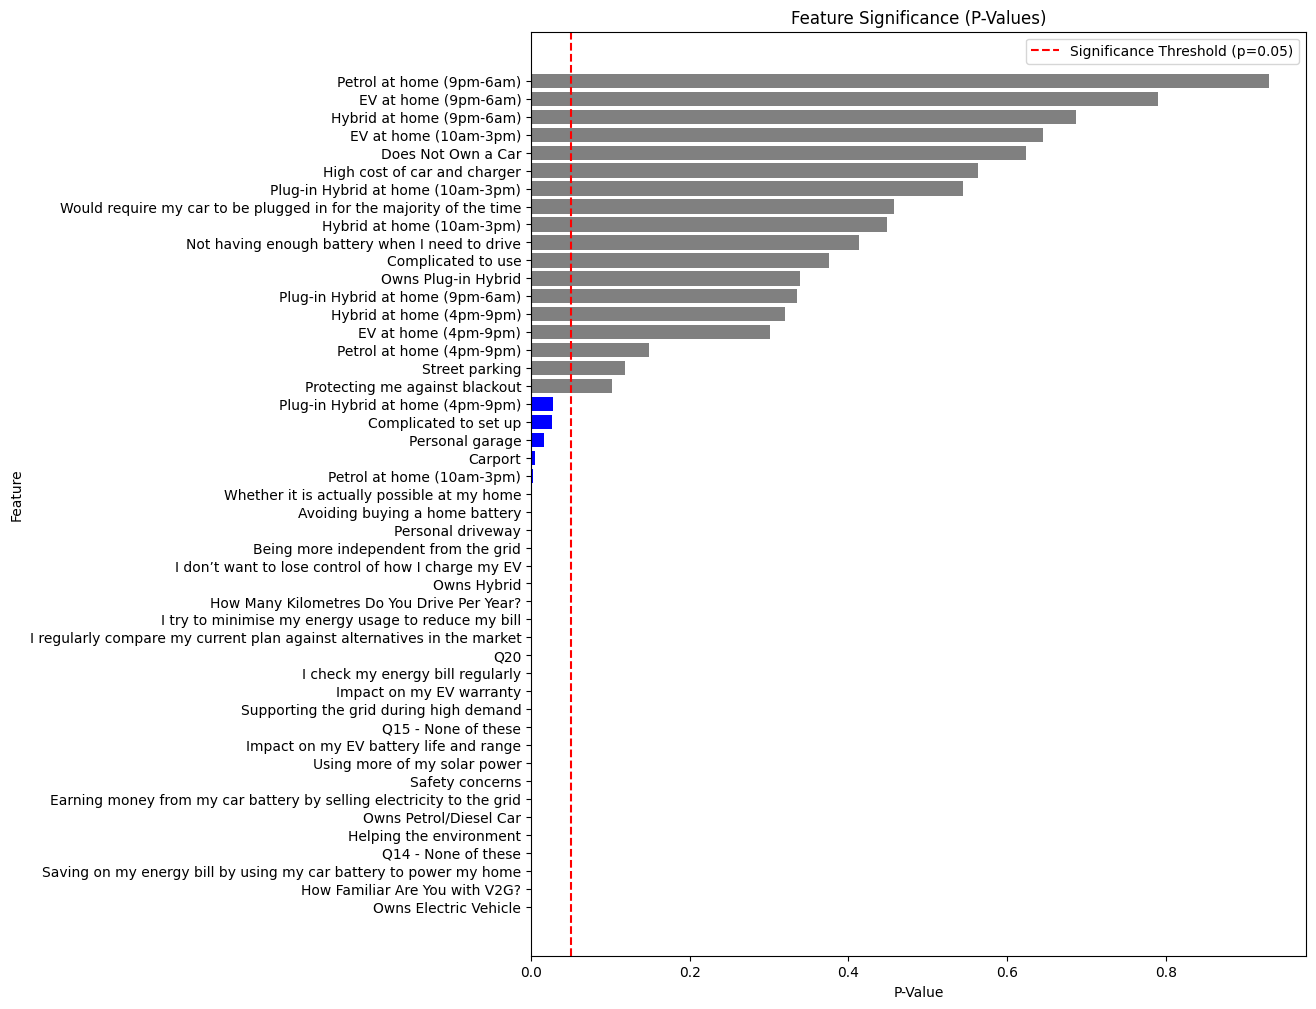

In [24]:
plot_p_value_barh(results_df)

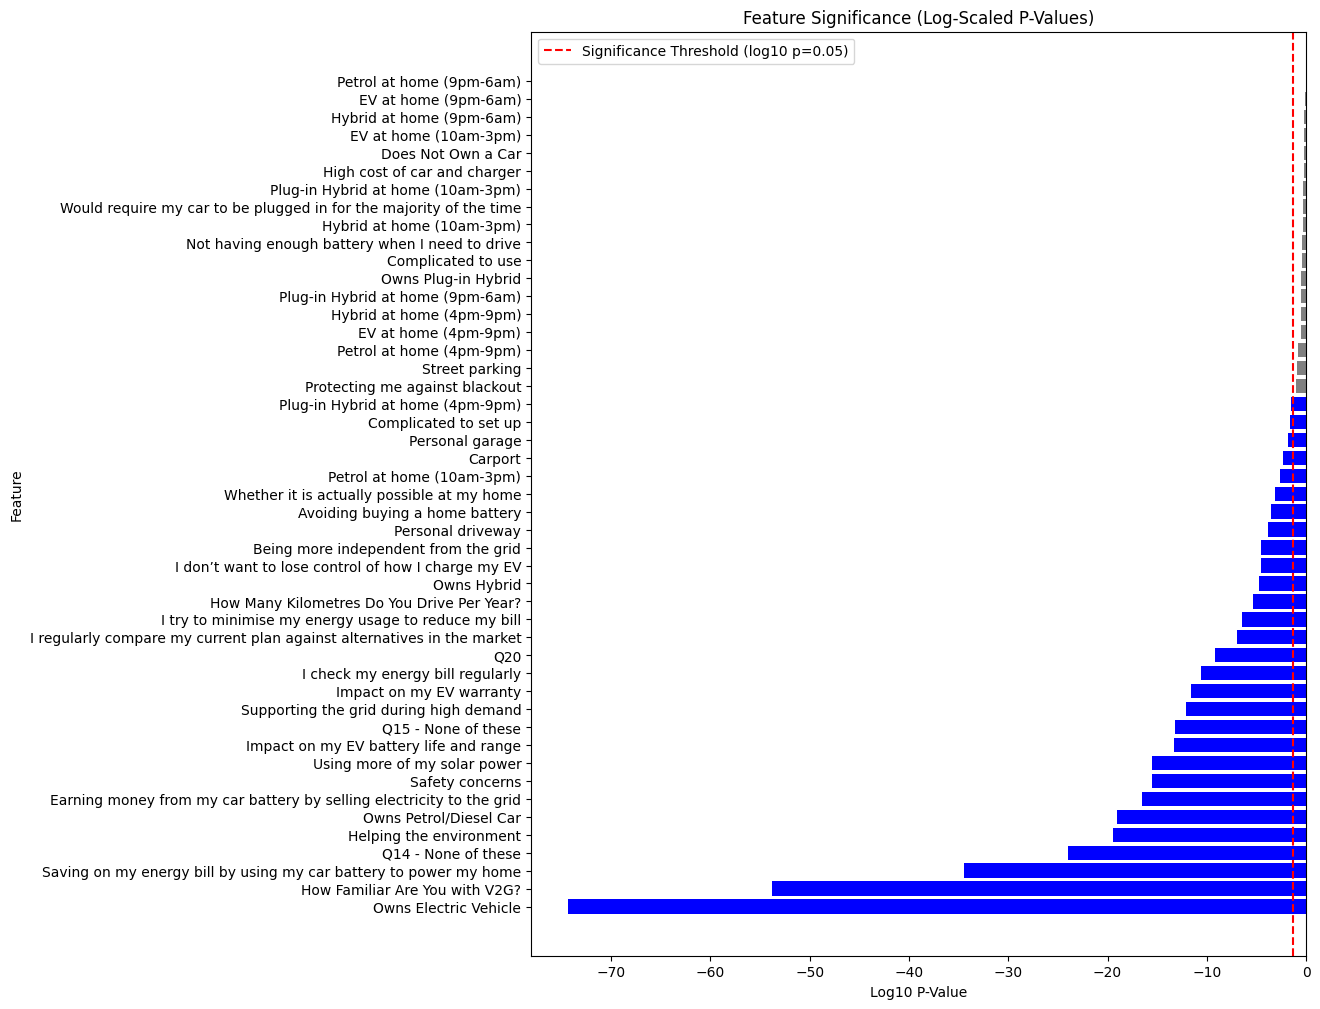

In [25]:
plot_log_p_value_barh(results_df)

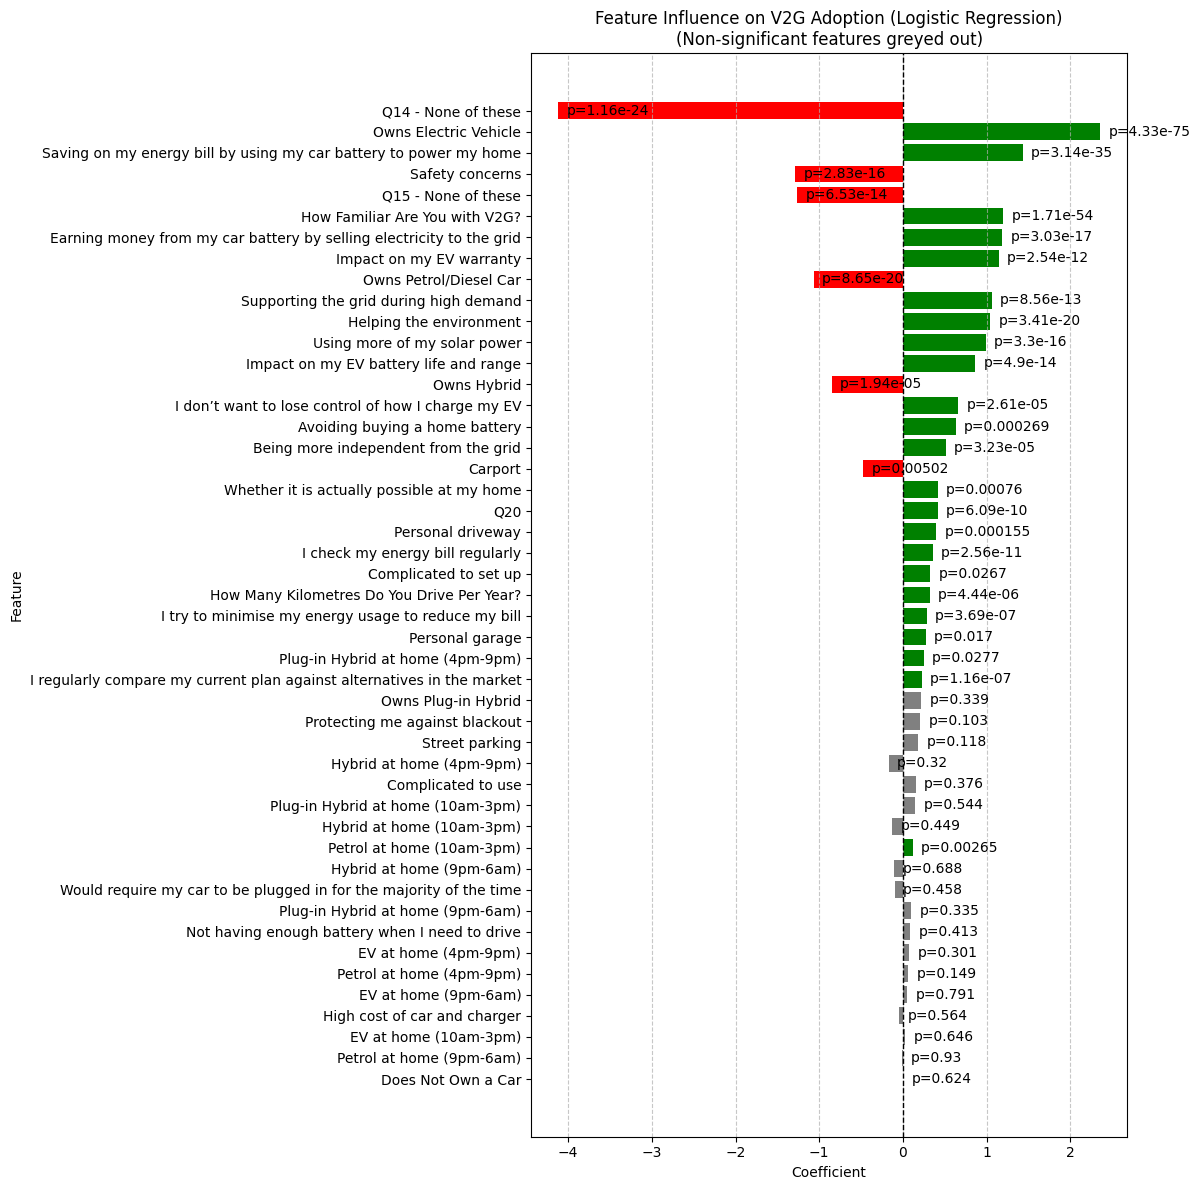

In [26]:
plot_coefficients_significance_barh(results_df, figsize=(12, 12))

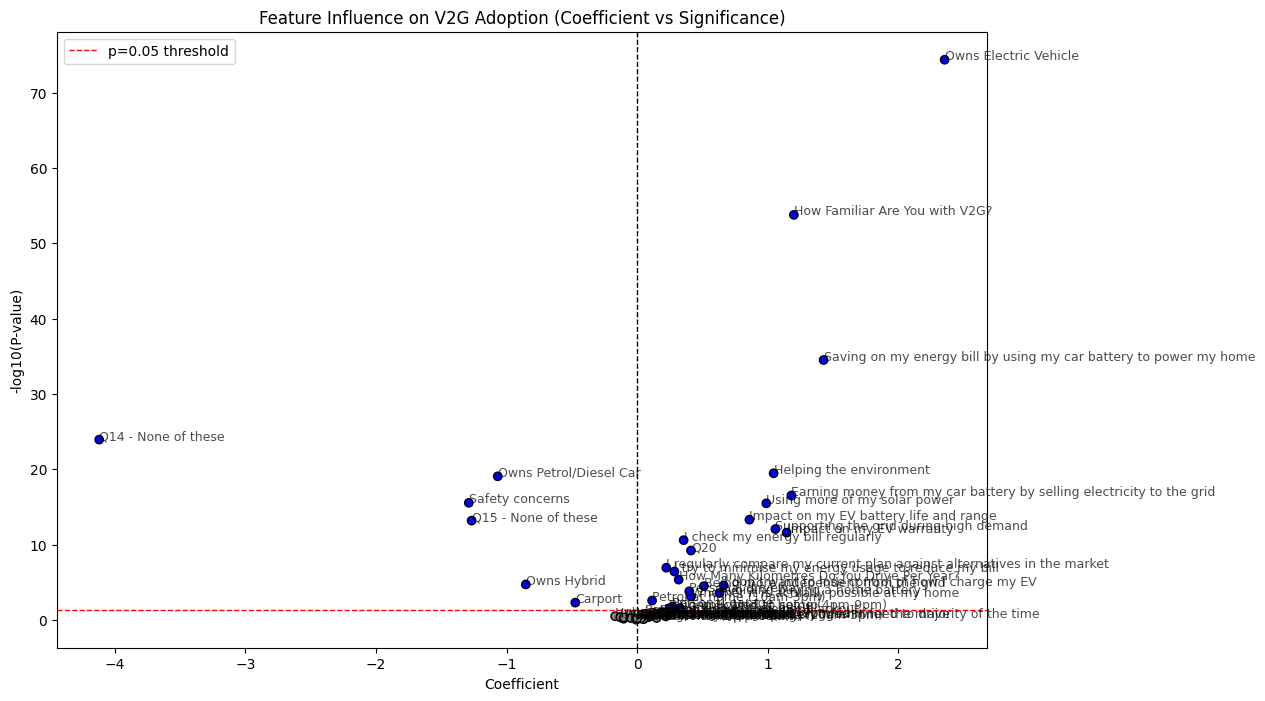

In [27]:
plot_coefficient_vs_significance(results_df)

# 4. Binomial Logistic Regression

## 4.1. Filtering my df based on the previous p-value analysis

In [28]:
columns_of_interest_filtered = filter_significant_features(
    results_df=results_df,
    feature_label_map=feature_label_map,
    columns_of_interest=columns_of_interest,
    target_variable=target_variable
)

# Force-include AgeBand and Q24
for col in ['AgeBand', 'Q24']:
    if col not in columns_of_interest_filtered:
        columns_of_interest_filtered.append(col)


Original columns count: 59
Filtered columns count: 30


In [29]:
filtered_df = df[columns_of_interest_filtered]
filtered_df

,Q9,Q2,Q6ax1_1,Q6ax3_2,Q20,Q1_1,Q1_2,Q1_4,Q3_1,Q3_2,...,Q15_7,Q15_8,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2,AgeBand,Q24
0,Somewhat familiar,"Less than 10,000",3.0,0.0,2,1,0,0,1,1,...,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0,Prefer not to say,Prefer not to say
1,Very familiar,"Less than 10,000",5.0,0.0,2,1,1,0,0,1,...,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,1,Prefer not to say,Prefer not to say
2,Not at all familiar,"20,001-50,000",2.0,0.0,2,1,0,0,1,1,...,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0,65+,"$1000-2000 a week / $52,000-$104,000 a year"
3,Not at all familiar,"Less than 10,000",0.0,0.0,2,0,0,1,0,0,...,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,0,55-64 years,Prefer not to say
4,Very familiar,"20,001-50,000",5.0,0.0,3,1,1,1,1,1,...,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1,45-54 years,Prefer not to say
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",0.0,0.0,2,0,1,0,0,1,...,1,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,1,55-64 years,Prefer not to say
1354,Somewhat familiar,"Less than 10,000",5.0,0.0,2,1,0,0,0,0,...,0,1,1,0,Strongly agree,Somewhat agree,Somewhat agree,0,65+,"$1000-2000 a week / $52,000-$104,000 a year"
1355,Very familiar,"10,000-20,000",4.0,0.0,2,1,1,0,0,1,...,1,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,1,65+,"$2000-3000 a week / $104,000-$156,000 a year"
1356,Very familiar,"10,000-20,000",0.0,0.0,1,0,1,0,0,0,...,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,1,65+,"Less than $500 a week / Less than $26,000 a year"


In [30]:
filtered_df['Q24'].unique()

array(['Prefer not to say', '$1000-2000 a week / $52,000-$104,000 a year',
       '$500-1000 a week / $26,000-$52,000 a year',
       'Less than $500 a week / Less than $26,000 a year',
       '$2000-3000 a week / $104,000-$156,000 a year',
       '$3000-4000 a week / $156,000-$208,000 a year',
       '$4000+ a week / $208,000+ a year'], dtype=object)

## 4.2. Running regression

In [31]:
filtered_df['Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
filtered_df['Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)

C:\Users\24417507\AppData\Local\Temp\ipykernel_26948\3615609723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
C:\Users\24417507\AppData\Local\Temp\ipykernel_26948\3615609723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)


In [32]:
print("Checking if any feature column is missing data...")
print(filtered_df.isnull().sum())

print("\nChecking unique values in target variable (Q10_2):")
print(filtered_df[target_variable].unique())

print("\nChecking number of non-missing rows in dataset:")
valid_rows = filtered_df.dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")


Checking if any feature column is missing data...
Q9         0
Q2         0
Q6ax1_1    0
Q6ax3_2    0
Q20        0
Q1_1       0
Q1_2       0
Q1_4       0
Q3_1       0
Q3_2       0
Q3_3       0
Q14_1      0
Q14_2      0
Q14_3      0
Q14_4      0
Q14_5      0
Q14_6      0
Q14_8      0
Q14_99     0
Q15_2      0
Q15_3      0
Q15_5      0
Q15_7      0
Q15_8      0
Q15_10     0
Q15_99     0
Q7_1       0
Q7_2       0
Q7_3       0
Q10_2      0
AgeBand    0
Q24        0
dtype: int64

Checking unique values in target variable (Q10_2):
[0 1]

Checking number of non-missing rows in dataset:
Valid rows: 1358 / 1358


In [33]:
# Let's confirm all columns in columns_of_interest_filtered have a transformer
for col in columns_of_interest_filtered:
    transformer_func = TRANSFORMERS_q6a.get(col, fallback_text_to_float)
    print(f"Column {col}: transformer = {transformer_func.__name__ if transformer_func else 'None'}")

Column Q9: transformer = text_to_code_q9
Column Q2: transformer = text_to_code_q2
Column Q6ax1_1: transformer = text_to_code_q6
Column Q6ax3_2: transformer = text_to_code_q6
Column Q20: transformer = fallback_text_to_float
Column Q1_1: transformer = text_to_code_binary
Column Q1_2: transformer = text_to_code_binary
Column Q1_4: transformer = text_to_code_binary
Column Q3_1: transformer = text_to_code_q3_parking
Column Q3_2: transformer = text_to_code_q3_parking
Column Q3_3: transformer = text_to_code_q3_parking
Column Q14_1: transformer = text_to_code_binary
Column Q14_2: transformer = text_to_code_binary
Column Q14_3: transformer = text_to_code_binary
Column Q14_4: transformer = text_to_code_binary
Column Q14_5: transformer = text_to_code_binary
Column Q14_6: transformer = text_to_code_binary
Column Q14_8: transformer = text_to_code_binary
Column Q14_99: transformer = text_to_code_binary
Column Q15_2: transformer = text_to_code_binary
Column Q15_3: transformer = text_to_code_binary
Co

In [34]:
# --- 1) Force-include AgeBand and Q24 in the filtered set --------------------
columns_of_interest_filtered = filter_significant_features(
    results_df=results_df,
    feature_label_map=feature_label_map,
    columns_of_interest=columns_of_interest,
    target_variable=target_variable
)

for must_keep in ['AgeBand', 'Q24']:
    if must_keep not in columns_of_interest_filtered and must_keep in df.columns:
        columns_of_interest_filtered.append(must_keep)

# --- 2) Define robust transformers for AgeBand and Q24 (ordinal encoding) ----
# Edit these maps to match your exact labels (use print(df['AgeBand'].unique()) to confirm)
AGEBAND_MAP = {
    '18–24': 1, '25–34': 2, '35–44': 3, '45–54': 4, '55–64': 5, '65+': 6
}

# Likewise, adapt to your income bands (check print(df['Q24'].unique()))
INCOME_MAP = {
    'Under $20k': 1, '$20k–$40k': 2, '$40k–$60k': 3, '$60k–$80k': 4,
    '$80k–$100k': 5, '$100k–$150k': 6, '$150k–$200k': 7, '$200k+': 8
}

def encode_ageband(x):
    if pd.isna(x):
        return np.nan
    return AGEBAND_MAP.get(str(x).strip(), np.nan)  # unseen → NaN so you notice

def encode_incomeband(x):
    if pd.isna(x):
        return np.nan
    return INCOME_MAP.get(str(x).strip(), np.nan)

# --- 3) Extend your transformer dict so the model knows how to handle them ---
# You already have TRANSFORMERS and then created TRANSFORMERS_q6a = TRANSFORMERS.copy()
# We’ll add (or overwrite) entries for AgeBand and Q24:
TRANSFORMERS_q6a = TRANSFORMERS.copy()
TRANSFORMERS_q6a.update({
    'AgeBand': encode_ageband,
    'Q24': encode_incomeband,
})

# --- 4) Build filtered_df safely and patch specific NA handling you already had ---
filtered_df = df[columns_of_interest_filtered].copy()

# Your existing NA patches (avoid chained assignment warnings with .loc)
if 'Q6ax1_1' in filtered_df.columns:
    filtered_df.loc[:, 'Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
if 'Q6ax3_2' in filtered_df.columns:
    filtered_df.loc[:, 'Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)

# Optional: if you prefer to impute Age/Income rather than drop rows, you can do:
# filtered_df.loc[:, 'AgeBand'] = filtered_df['AgeBand'].fillna('45–54')  # e.g., median band
# filtered_df.loc[:, 'Q24'] = filtered_df['Q24'].fillna('$80k–$100k')     # e.g., median band

print("Checking if any feature column is missing data...")
print(filtered_df.isnull().sum())

print("\nChecking unique values in target variable (Q10_2):")
print(filtered_df[target_variable].unique())

print("\nChecking number of non-missing rows in dataset:")
valid_rows = filtered_df.dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")

Original columns count: 59
Filtered columns count: 30
Checking if any feature column is missing data...
Q9         0
Q2         0
Q6ax1_1    0
Q6ax3_2    0
Q20        0
Q1_1       0
Q1_2       0
Q1_4       0
Q3_1       0
Q3_2       0
Q3_3       0
Q14_1      0
Q14_2      0
Q14_3      0
Q14_4      0
Q14_5      0
Q14_6      0
Q14_8      0
Q14_99     0
Q15_2      0
Q15_3      0
Q15_5      0
Q15_7      0
Q15_8      0
Q15_10     0
Q15_99     0
Q7_1       0
Q7_2       0
Q7_3       0
Q10_2      0
AgeBand    0
Q24        0
dtype: int64

Checking unique values in target variable (Q10_2):
[0 1]

Checking number of non-missing rows in dataset:
Valid rows: 1358 / 1358


In [35]:
# Confirm all columns have a transformer (will show AgeBand/Q24 are mapped)
for col in columns_of_interest_filtered:
    transformer_func = TRANSFORMERS_q6a.get(col, fallback_text_to_float)
    print(f"Column {col}: transformer = {transformer_func.__name__ if transformer_func else 'None'}")

Column Q9: transformer = text_to_code_q9
Column Q2: transformer = text_to_code_q2
Column Q6ax1_1: transformer = fallback_text_to_float
Column Q6ax3_2: transformer = fallback_text_to_float
Column Q20: transformer = fallback_text_to_float
Column Q1_1: transformer = text_to_code_binary
Column Q1_2: transformer = text_to_code_binary
Column Q1_4: transformer = text_to_code_binary
Column Q3_1: transformer = text_to_code_q3_parking
Column Q3_2: transformer = text_to_code_q3_parking
Column Q3_3: transformer = text_to_code_q3_parking
Column Q14_1: transformer = text_to_code_binary
Column Q14_2: transformer = text_to_code_binary
Column Q14_3: transformer = text_to_code_binary
Column Q14_4: transformer = text_to_code_binary
Column Q14_5: transformer = text_to_code_binary
Column Q14_6: transformer = text_to_code_binary
Column Q14_8: transformer = text_to_code_binary
Column Q14_99: transformer = text_to_code_binary
Column Q15_2: transformer = text_to_code_binary
Column Q15_3: transformer = text_to_

In [36]:
# --- Force-include controls (you likely already did this) ---
for must_keep in ['AgeBand', 'Q24']:
    if must_keep not in columns_of_interest_filtered and must_keep in df.columns:
        columns_of_interest_filtered.append(must_keep)

# --- Build filtered df safely ---
filtered_df = df[columns_of_interest_filtered].copy()

# Your existing NA patches
if 'Q6ax1_1' in filtered_df.columns:
    filtered_df.loc[:, 'Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
if 'Q6ax3_2' in filtered_df.columns:
    filtered_df.loc[:, 'Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)

# --- Robust control encoding: Age (ordinal) + Income (one-hot) ---
# 1) AgeBand as ordinal; impute median code if missing
AGEBAND_MAP = {
    '18–24': 1, '25–34': 2, '35–44': 3, '45–54': 4, '55–64': 5, '65+': 6
}
def encode_ageband_safe(x):
    if pd.isna(x): 
        return np.nan
    # normalize dashes/spaces
    s = str(x).strip().replace('-', '–')
    return AGEBAND_MAP.get(s, np.nan)

filtered_df.loc[:, 'AgeBand'] = filtered_df['AgeBand'].apply(encode_ageband_safe)
if filtered_df['AgeBand'].isna().any():
    median_age_code = filtered_df['AgeBand'].median()
    filtered_df.loc[:, 'AgeBand'] = filtered_df['AgeBand'].fillna(median_age_code)

# 2) Income as dummies to avoid unseen-band issues
if 'Q24' in filtered_df.columns:
    # Clean strings first to reduce dupes from whitespace/dash differences
    filtered_df.loc[:, 'Q24'] = (
        filtered_df['Q24']
        .astype(str)
        .str.strip()
        .str.replace('-', '–', regex=False)
    )
    filtered_df = pd.get_dummies(filtered_df, columns=['Q24'], drop_first=True)

# --- Make a transformers copy that matches our pre-processing ---
TRANSFORMERS_safe = TRANSFORMERS_q6a.copy()
# We already encoded AgeBand numerically here → no-op in the model step
TRANSFORMERS_safe['AgeBand'] = (lambda x: x)
# After get_dummies, there is no single 'Q24' column anymore
TRANSFORMERS_safe.pop('Q24', None)

# --- Define predictors explicitly WITHOUT the target --------------------------
predictors = [c for c in filtered_df.columns if c != target_variable]

# (Optional) quick sanity checks
print("Any NaNs left in predictors?", filtered_df[predictors].isna().any().any())
print("Non-numeric predictors:",
      [c for c in predictors if not np.issubdtype(filtered_df[c].dtype, np.number)])


Any NaNs left in predictors? False
Non-numeric predictors: ['Q9', 'Q2', 'Q20', 'Q1_1', 'Q1_2', 'Q1_4', 'Q3_1', 'Q3_2', 'Q3_3', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5', 'Q14_6', 'Q14_8', 'Q14_99', 'Q15_2', 'Q15_3', 'Q15_5', 'Q15_7', 'Q15_8', 'Q15_10', 'Q15_99', 'Q7_1', 'Q7_2', 'Q7_3']


C:\Users\24417507\AppData\Local\Temp\ipykernel_26948\3603673485.py:27: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  filtered_df.loc[:, 'AgeBand'] = filtered_df['AgeBand'].apply(encode_ageband_safe)


In [37]:
# --- Fit the model (now controlling for AgeBand + Income dummies) -------------
model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
    filtered_df,              
    predictors,               
    target_variable,
    TRANSFORMERS_safe,        
    do_normalize=True,
    test_split_ratio=0.2
)

Unique values in y_train: (array([0, 1]), array([507, 531], dtype=int64))
Unique values in y_test: (array([0, 1]), array([118, 142], dtype=int64))
Train Accuracy: 81.02%
Test Accuracy: 83.46%


In [38]:
print(filtered_df.shape)
print(len(predictors), predictors[:10])
print(filtered_df[predictors].isna().sum().sum(), "total NaNs in X")
print(filtered_df[target_variable].isna().sum(), "NaNs in y")

(1358, 37)
36 ['Q9', 'Q2', 'Q6ax1_1', 'Q6ax3_2', 'Q20', 'Q1_1', 'Q1_2', 'Q1_4', 'Q3_1', 'Q3_2']
0 total NaNs in X
0 NaNs in y


In [39]:
# Previous model fit:
'''model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
    filtered_df,  
    columns_of_interest_filtered,
    target_variable,  
    TRANSFORMERS_q6a,  
    do_normalize=True,
    test_split_ratio=0.2
)'''

'model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(\n    filtered_df,  \n    columns_of_interest_filtered,\n    target_variable,  \n    TRANSFORMERS_q6a,  \n    do_normalize=True,\n    test_split_ratio=0.2\n)'

# 5. Visualisation of results

## 5.1. Coefficients

In [40]:
# Extract coefficients
coefs_binary = model_binary.coef_[0]  # Shape: (1, n_features), so take [0]

# Create DataFrame for visualization
coefs_binary_df = pd.DataFrame({'Feature': predictors, 'Coefficient': coefs_binary})
coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)
coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)

In [41]:
coefs_binary_df

,Feature,Coefficient
0,How Familiar Are You with V2G?,1.293240
6,Owns Electric Vehicle,1.188332
11,Earning money from my car battery by selling e...,0.979270
12,Saving on my energy bill by using my car batte...,0.775071
13,Helping the environment,0.703983
14,Using more of my solar power,0.645575
15,Supporting the grid during high demand,0.587531
17,Avoiding buying a home battery,0.559466
26,I check my energy bill regularly,0.552249
16,Being more independent from the grid,0.492319


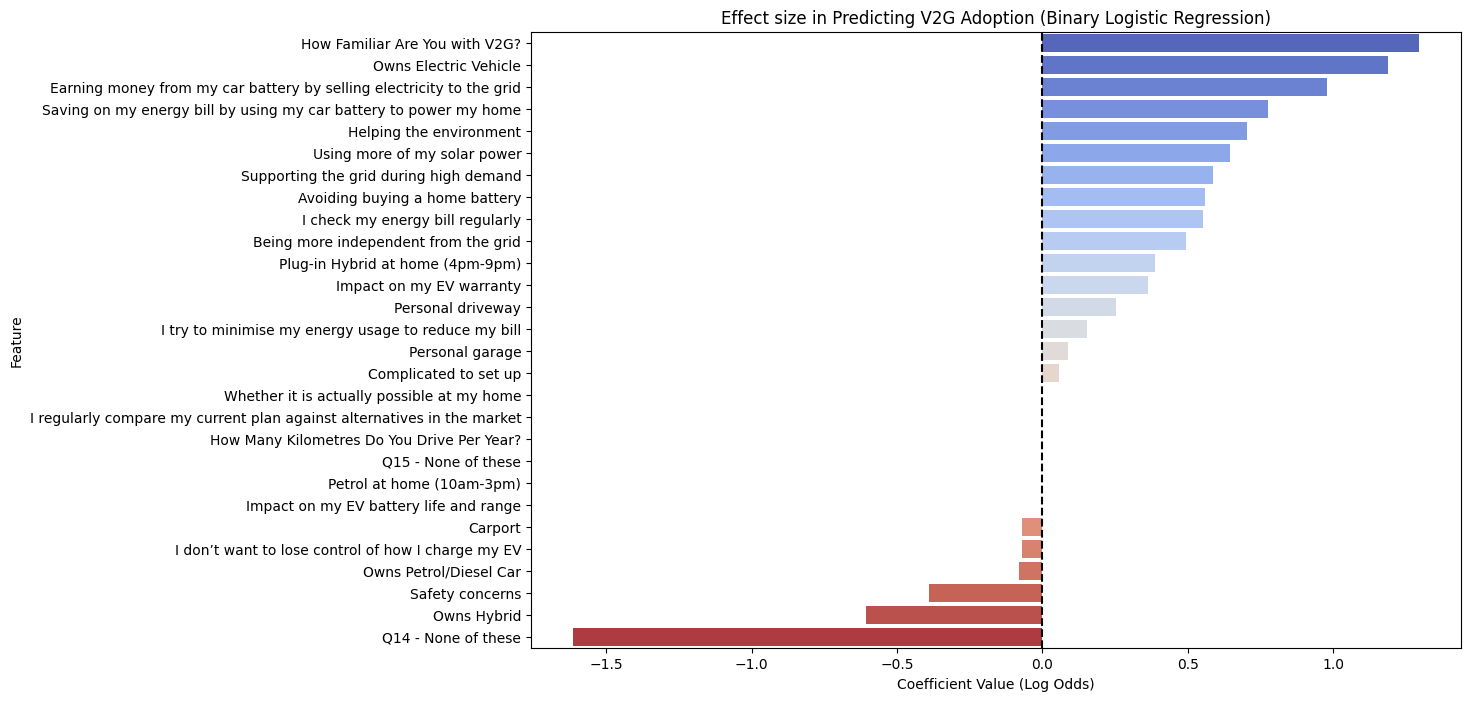

In [42]:
plot_coefficients_barplot(coefs_binary_df)

## 5.2. Odds Ratio

In [43]:
coefs_binary_df["Odds Ratio"] = np.exp(coefs_binary_df["Coefficient"])
coefs_binary_df.sort_values(by="Odds Ratio", ascending=False, inplace=True)

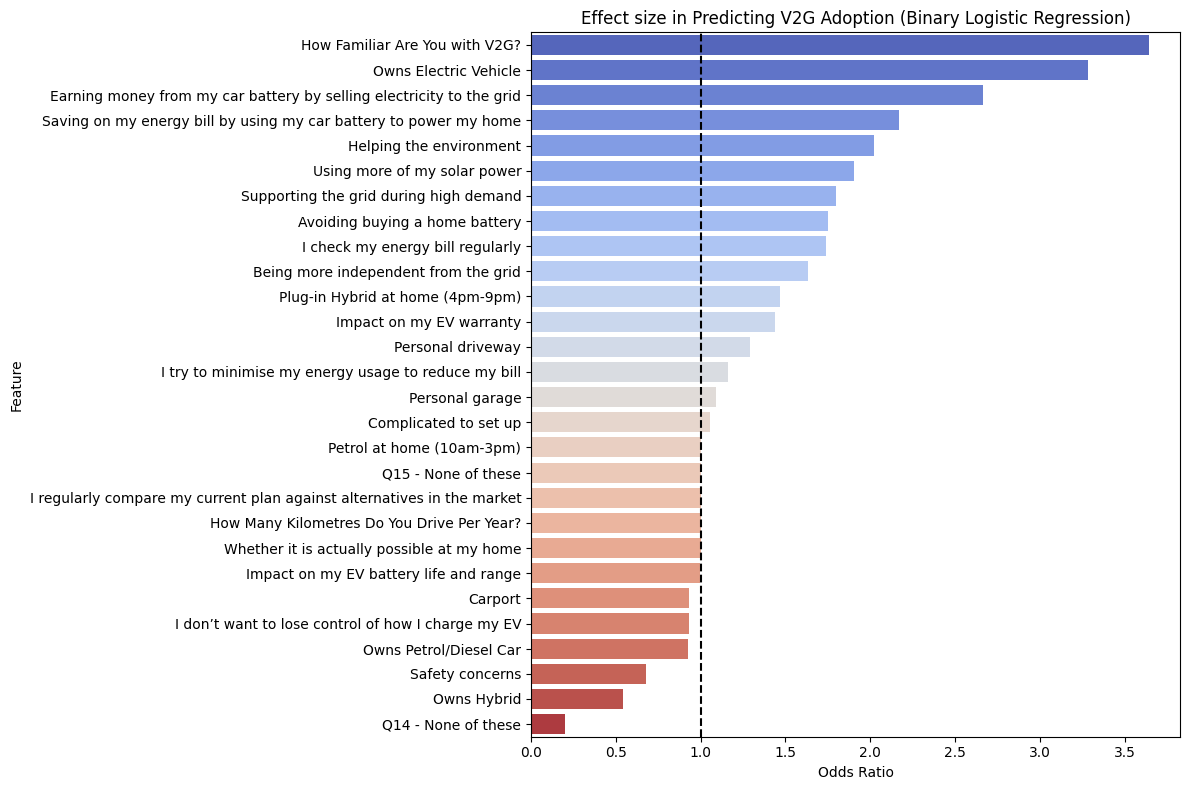

In [44]:
plot_odds_ratios_barplot(coefs_binary_df)

In [45]:
# Sort features by absolute coefficient magnitude for better visualization
coefs_binary_df["abs_coef"] = coefs_binary_df["Coefficient"].abs()
coefs_binary_df = coefs_binary_df.sort_values(by="abs_coef", ascending=False)

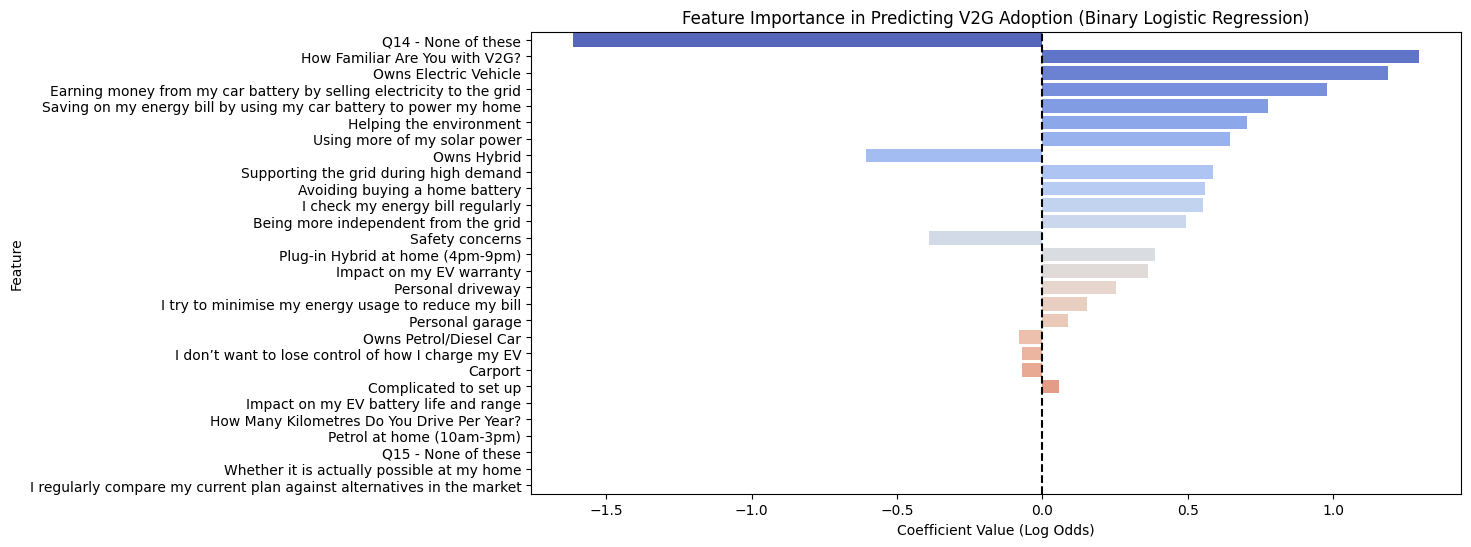

In [46]:
plot_coefficients_by_abs(coefs_binary_df)

In [47]:
# Predict on test data
y_pred_binary = model_binary.predict(X_test)
# Compute accuracy
accuracy_binary = accuracy_score(y_test, y_pred_binary)
print(f"Model Accuracy: {accuracy_binary:.2%}")

Model Accuracy: 83.46%


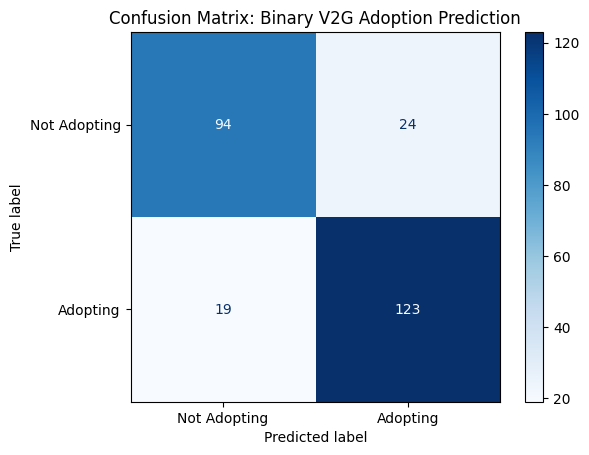

In [48]:
plot_binary_confusion_matrix(y_test, y_pred_binary, labels=["Not Adopting", "Adopting"])

# 6. Correlation matrix

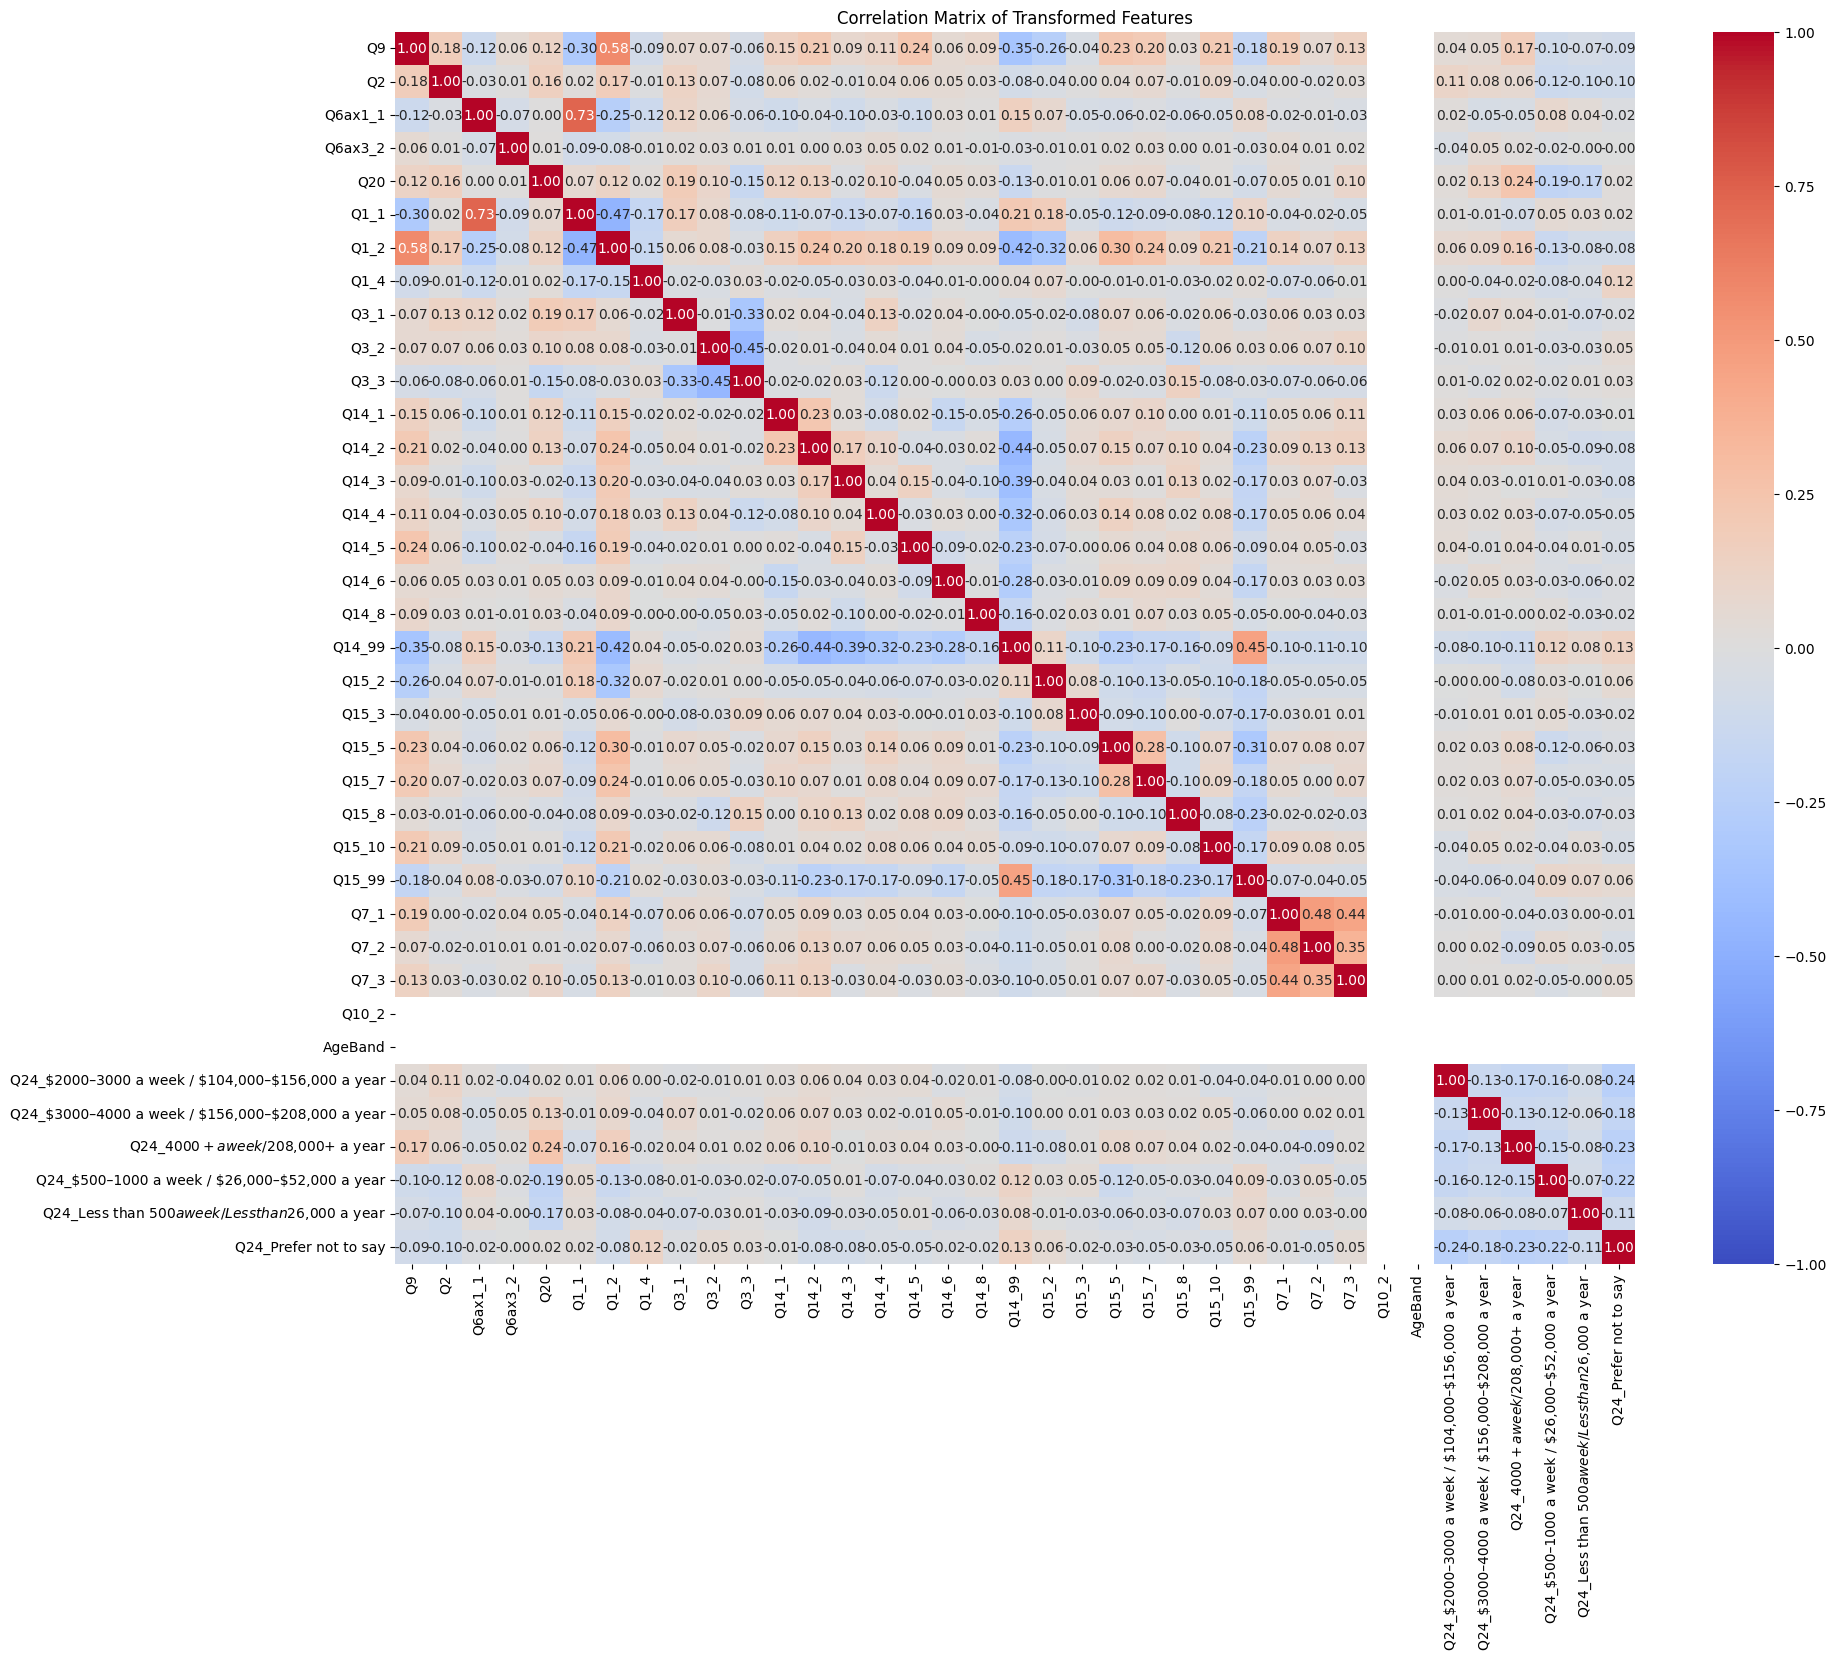

In [49]:
corr_mat = transform_and_plot_correlation(
    filtered_df, 
    TRANSFORMERS,
    figsize=(20, 16),
    title="Correlation Matrix of Transformed Features"
)

# 7. Comparison between non-controlled and controlled results

In [79]:
coefs_binary_df_not_controlled = pd.read_csv('./results/binary_coefficients_not_controlled.csv')

In [82]:
coefs_controlled = coefs_binary_df[['Feature', 'Coefficient']].rename(
    columns={'Coefficient': 'Coefficient_Controlled'}
)

coefs_not_controlled = coefs_binary_df_not_controlled[['Feature', 'Coefficient']].rename(
    columns={'Coefficient': 'Coefficient_NotControlled'}
)

In [83]:
comparison_df = pd.merge(
    coefs_not_controlled,
    coefs_controlled,
    on="Feature",
    how="outer"   # keep all features from both models
)

# Compute the difference
comparison_df['Difference'] = (
    comparison_df['Coefficient_Controlled'] - comparison_df['Coefficient_NotControlled']
)

# Optional: also add odds ratios
comparison_df['OR_NotControlled'] = np.exp(comparison_df['Coefficient_NotControlled'])
comparison_df['OR_Controlled'] = np.exp(comparison_df['Coefficient_Controlled'])


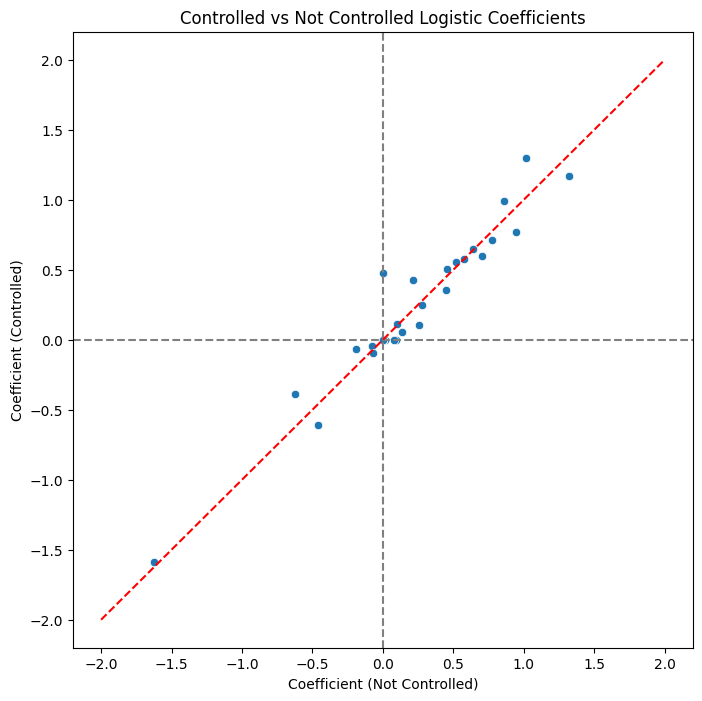

In [84]:
plt.figure(figsize=(8, 8))
sns.scatterplot(
    x="Coefficient_NotControlled",
    y="Coefficient_Controlled",
    data=comparison_df
)
plt.axhline(0, color="grey", linestyle="--")
plt.axvline(0, color="grey", linestyle="--")
plt.plot([-2, 2], [-2, 2], color="red", linestyle="--")  # y=x reference line
plt.xlabel("Coefficient (Not Controlled)")
plt.ylabel("Coefficient (Controlled)")
plt.title("Controlled vs Not Controlled Logistic Coefficients")
plt.show()


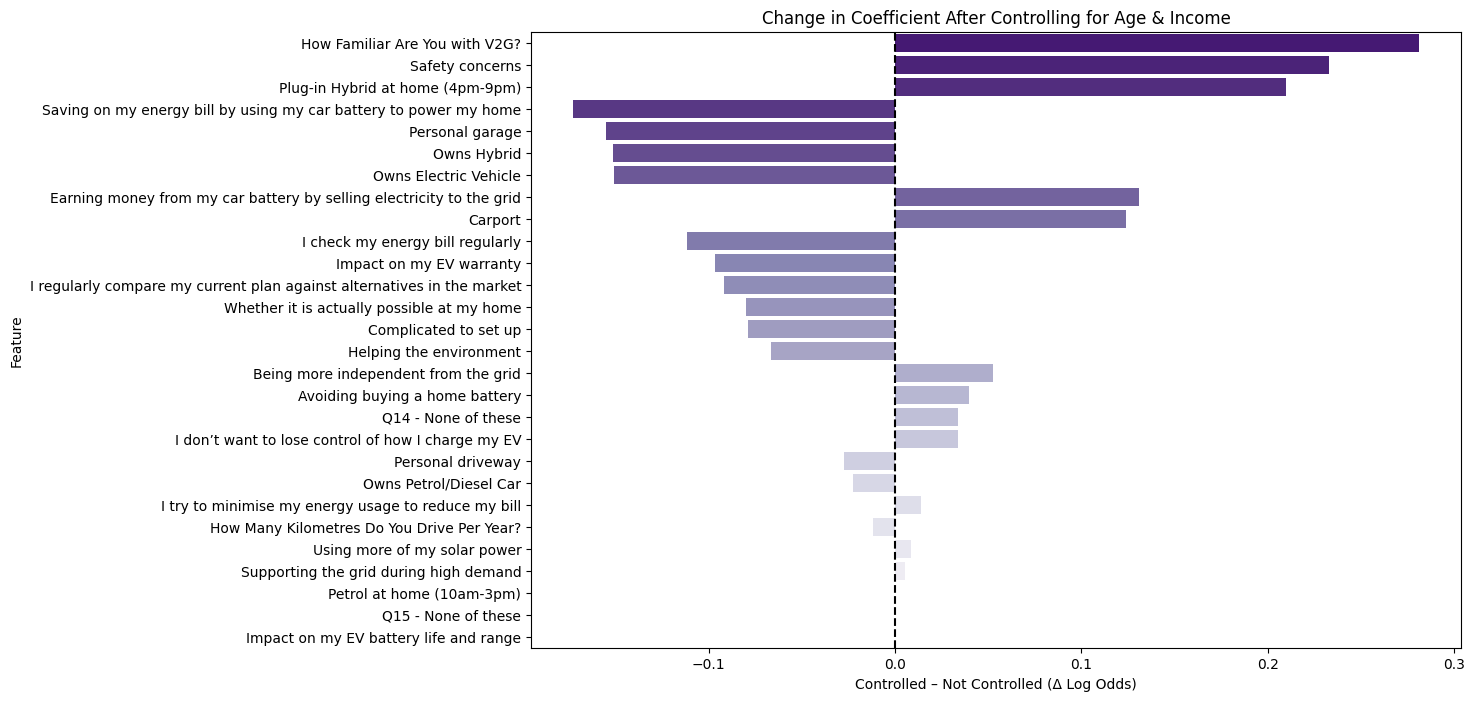

In [93]:
plt.figure(figsize=(12, 8))
plot_df = comparison_df.sort_values("Difference", key=abs, ascending=False)
sns.barplot(
    x="Difference",
    y="Feature",
    data=plot_df,
    palette="Purples_r"
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Change in Coefficient After Controlling for Age & Income")
plt.xlabel("Controlled – Not Controlled (Δ Log Odds)")
plt.ylabel("Feature")
plt.show()


In [88]:
def plot_coefficients_comparison(comparison_df,
                                 feature_col="Feature",
                                 coef_not="Coefficient_NotControlled",
                                 coef_ctrl="Coefficient_Controlled",
                                 title="Effect size in Predicting V2G Adoption\n(Controlled vs Not Controlled)"):
    """
    Plots side-by-side barplots of coefficients (log-odds) from two logistic regressions:
    one with controls and one without.

    Parameters
    ----------
    comparison_df : pd.DataFrame
        Must contain columns [feature_col, coef_not, coef_ctrl]
    feature_col : str
        Column name for features (labels on y-axis)
    coef_not : str
        Column name for coefficients from the not-controlled model
    coef_ctrl : str
        Column name for coefficients from the controlled model
    title : str
        Title of the plot
    """
    # Drop rows with missing feature names or coefficients
    clean_df = comparison_df.dropna(subset=[feature_col, coef_not, coef_ctrl]).copy()

    # Reshape to long form for seaborn
    plot_df = clean_df.melt(
        id_vars=feature_col,
        value_vars=[coef_not, coef_ctrl],
        var_name="Model",
        value_name="Coefficient"
    )

    # Rename for nicer legend labels
    plot_df["Model"] = plot_df["Model"].replace({
        coef_not: "Not Controlled",
        coef_ctrl: "Controlled"
    })

    # Sort features by the controlled coefficients (optional, for consistent order)
    order = (clean_df
             .sort_values(coef_ctrl, ascending=False)[feature_col]
             .tolist())

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x="Coefficient", y=feature_col,
        hue="Model", data=plot_df,
        palette="Set1", order=order
    )
    plt.axvline(x=0, color='black', linestyle='--')
    plt.title(title)
    plt.xlabel("Coefficient Value (Log Odds)")
    plt.ylabel("Feature")
    plt.legend(title="Model", loc="best")
    plt.tight_layout()
    plt.show()


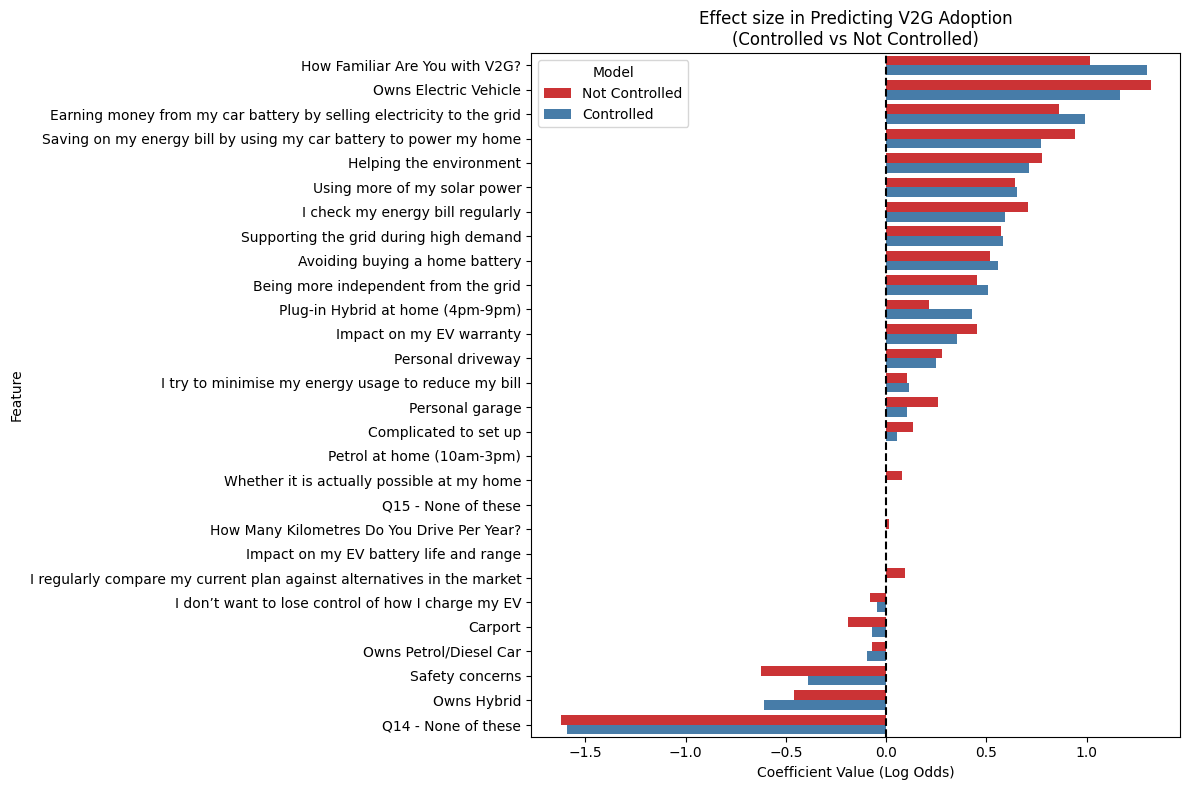

In [89]:
plot_coefficients_comparison(comparison_df)
